# Matrix Factorization

We will experiment with the recent MovieLens 25M Dataset and build a recommender system using two approaches:
* Factorizing the user-item matrix using Spark ALS implementation
* Factorizing the item-item PMI maatrix using randomized SVD

In both settings we will index the item embeddings and inspect their quality using KNN queries.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   187M      0  0:00:01  0:00:01 --:--:--  187M


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
import findspark
findspark.init()

In [6]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf, StorageLevel
import pyspark.sql.functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [7]:
conf = (
    SparkConf()
    .set('spark.ui.port', '4050')
    .set("spark.driver.memory", "16g")
    .set('spark.driver.maxResultsSize', '8g')
)
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()
ss = spark

### Download the dataset

In [8]:
!wget http://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m

--2022-05-20 09:20:17--  http://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  78.2MB/s    in 3.4s    

2022-05-20 09:20:21 (73.2 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


### Loading the ratings dataset

In [9]:
movies_df = spark.read.csv('ml-25m/movies.csv', header=True, inferSchema=True).cache()
ratings_df = spark.read.csv('ml-25m/ratings.csv', header=True, inferSchema=True)

# Part 1 : Alternating least squares

### Split the dataset
We want to randomly split the dataset into train and test parts

In [ ]:
(training_df, validation_df) = ratings_df.randomSplit([0.8, 0.2])

In [ ]:
training_df.count()

### Build ALS model
Using the Spark ALS implementation described here https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html
Build a model using the ml-25m dataset.

How long does the training take, change the rank (i.e. the dimension of the vectors) from 10 to 20. How does that affect training speed ?

In [ ]:
from pyspark.ml.recommendation import ALS
import time

ranks = [10,15,20]
models = []
training_time = []

for rank in ranks:
  start_time = time.time()
  als = ALS(rank=rank, maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
  model = als.fit(training_df)
  models.append(model)
  training_time.append(time.time() - start_time)

In [ ]:
from matplotlib.pyplot import plot
%matplotlib inline
plot(ranks, training_time)

# processing time seems linear as long as we don't have memory issues to deal-with.

### Evaluation
Using the code described in the Spark documentation, evaluate how good your model is doing on the test set.
The goal is to predict the held out ratings.
A good metric could be RMSE or MAE.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(validation_df)
evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = evaluator.evaluate(predictions)
print(f"MAE = {mae}")

### Inspecting the results

Retrieve the movie vectors from the learned model object (the property is called itemFactors).
and `collect` all these vectors in a list.

In [ ]:
movie_vectors_df = (
    model.itemFactors
    .join(movies_df.withColumnRenamed('movieId', 'id'), 'id')
    .select('title', 'features')
)

Now we need to create a dictionary mapping the movieId to it's title to ease the inspection. 
Load the `movies.csv` file using pyspark or pandas and create a `dict` movieId -> title.

In [ ]:
movie_vect_dict = {r['title'] : r['features'] for r in movie_vectors_df.collect()}

### Using Nearest neighbours

Pick a few movies, and for each of them, find-out the top 5 nearest neighbours. This is very similar to an optional question of the PLSA project...

In [ ]:
title_vector_array = movie_vectors_df.collect()
titles = [r['title'] for r in title_vector_array]
vectors = [r['features'] for r in title_vector_array]

In [ ]:
import numpy
from numpy import linalg as LA
import heapq
# naive knn with queue, using numpy to batch vector operations
def knn(query, k, titles, vectors):
  start_time = time.time()
  nb_movies = len(titles)
  diff = numpy.array(vectors) - numpy.array(query)
  distances = LA.norm(diff, axis=1)
  indices = heapq.nlargest(k, range(0, nb_movies), key=lambda x: -distances[x])
  ret = [(titles[i], distances[i]) for i in indices]
  print(f"{time.time() - start_time}")
  return ret

In [ ]:
def analyze(i):
  print(f"Query title : {titles[i]}")
  query_vec = vectors[i]
  ret = knn(query_vec, 10, titles, vectors)
  for res in ret:
    print(res)

In [ ]:
analyze(4)

# Part 2 : PMI and RSVD


We now are going to factorize the item-item PMI matrix using randomized SVD.

## Size estimation

Let's first estimate the size of the matrix we are about to build.

Reminder : we will generate the co-occurence matrix $C$ from all the pairs of
movies that we find in users ratings. 
This matrix can be big.

Namely, if a user has rated movies `(1, 2, 3, 4)`, we will generate 6 pairs :
`(1, 2), (1, 3), (2, 3), (1, 4), (2, 4), (3, 4)`.

Formally, if a user has rated $n$ movies, he will generate $n \cdot (n - 1) \; / \; 2$ pairs. We should be careful of users that have rated a lot of movies.


In [10]:
def number_of_pairs_to_be_generated(ratings_df):
  ratings_count_by_user_df = (
      ratings_df
      .groupby('userId')
      .agg(F.count('*').alias('count'))
      .sort(F.col('count').desc())
  )

  return int((
      ratings_count_by_user_df
     .withColumn("n_pairs", F.col("count") * (F.col("count") - 1) / 2)
     .select(F.sum("n_pairs"))
  ).collect()[0]["sum(n_pairs)"])

print(
    f"Number of positive ratings : {ratings_df.count():,}"
    f", that should generate {number_of_pairs_to_be_generated(ratings_df):,} pairs"
)

Number of positive ratings : 25,000,095, that should generate 7,749,316,125 pairs


### Keep positive interactions

In [11]:
# first things first we only keep movies liked by user.
positive_ratings_df = ratings_df.filter(F.col('rating') >= 3.5).persist(StorageLevel.DISK_ONLY)
print(
    f"Number of positive ratings : {positive_ratings_df.count():,}"
    f", that should generate {number_of_pairs_to_be_generated(positive_ratings_df):,} pairs"
)

Number of positive ratings : 15,630,129, that should generate 2,584,443,643 pairs


### Keep meaningful movies

We will keep only movies having a sufficient amount of positive ratings.
First, that will make the computations lighter, second, it will prevent us from
computing embeddings for movies we have very little information on.

In [12]:
# There are not that many movies in the dataset, we can safely bring their rating counts to pandas
movie_counts_df = positive_ratings_df.groupby("movieId").count()
movie_counts_pdf = movie_counts_df.toPandas()
print(f"Number of Movies in original dataset : {len(movie_counts_pdf):,}")
movie_counts_pdf.head(3)

Number of Movies in original dataset : 47,396


,movieId,count
0,1088,5825
1,1580,26394
2,3175,9835


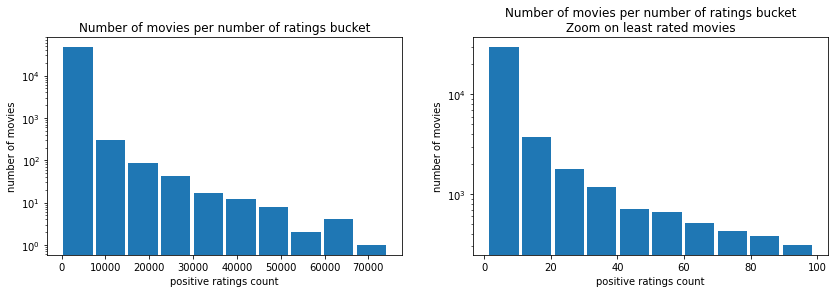

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(movie_counts_pdf["count"], log=True, rwidth=0.9)
axes[0].set_xlabel("positive ratings count")
axes[0].set_ylabel("number of movies")
axes[0].set_title("Number of movies per number of ratings bucket")

axes[1].hist(movie_counts_pdf["count"][movie_counts_pdf["count"] < 100], log=True, rwidth=0.9)
axes[1].set_xlabel("positive ratings count")
axes[1].set_ylabel("number of movies")
axes[1].set_title("Number of movies per number of ratings bucket\nZoom on least rated movies")
None

In [14]:
MIN_COUNT = 50
kept_movies_df = movie_counts_df.filter(F.col("count") > MIN_COUNT).select("movieId")
print(f"Number of Movies after filtering movies with less than {MIN_COUNT} ratings : {kept_movies_df.count():,}")

Number of Movies after filtering movies with less than 50 ratings : 10,183


In [15]:
filtered_ratings_df = positive_ratings_df.join(kept_movies_df, on="movieId")

print(
    f"Number of positive ratings : {filtered_ratings_df.count():,}"
    f", that should generate {number_of_pairs_to_be_generated(filtered_ratings_df):,} pairs"
)

Number of positive ratings : 15,365,441, that should generate 2,305,435,614 pairs


### Limit the number of pairs

We have way less movies but still almost all ratings and a lot of pairs ! 

In [16]:
# Let's look at how many ratings are done user by user
# When user has scored a lots of movies, the number of pairs he generates increases quadratically !
ratings_count_by_user_df = (
    filtered_ratings_df
    .groupby('userId')
    .agg(F.count('*').alias('count'))
    .sort(F.col('count').desc())
).persist(StorageLevel.DISK_ONLY)

ratings_count_by_user_df.show(5)

+------+-----+
|userId|count|
+------+-----+
| 72315| 4507|
|110971| 3703|
| 92046| 3390|
| 80974| 3337|
| 20055| 3269|
+------+-----+
only showing top 5 rows



In [17]:
# We will sample user ratings to limit the maximum number of ratings per user (in expectation)
EXPECTED_MAX_USER_RATINGS = 40
ratings_sampled_df = (
  filtered_ratings_df
  .join(ratings_count_by_user_df, 'userId')
  .filter(F.rand() < (EXPECTED_MAX_USER_RATINGS / F.col('count')))
  .select('userId', 'movieId')
  .repartition('userId')
  .persist(StorageLevel.DISK_ONLY)
)

In [18]:
print(
    f"Number of positive ratings after sampling : {ratings_sampled_df.count():,}"
    f", that should generate {number_of_pairs_to_be_generated(ratings_sampled_df):,} event pairs"
)

Number of positive ratings after sampling : 5,187,920, that should generate 90,626,859 event pairs


### Creating the PMI matrix

Reminder, the PMI matrix writes
$$
PMI(i, j) = \log\left(\frac{p(i, j)}{p(i)p(j)}\right)
$$
that we estimate with
$$
\widehat{PMI}(i, j) = \log\left(\frac{C_{i, j} \cdot n}{C_i \cdot  C_j}\right)
$$
where
* $C_{i, j}$ is the number of pairs (i, j) (i.e. the number of users that have
  given a positive feedback for both movie i and movie j.
* $C_{i}$ is total the number of pairs containing i
* $C_{j}$ is total the number of pairs containing j
* $n$ is the total number of pairs

#### Step 1 : compute co-occurence matrix $C_{i,j}$

In [19]:
cooccurence_df = (
    ratings_sampled_df.withColumnRenamed('movieId', 'movieId1')
    .join(ratings_sampled_df.withColumnRenamed('movieId', 'movieId2'), 'userId')
    .filter(F.col("movieId1") < F.col("movieId2"))
    .groupby(F.col("movieId1"), F.col("movieId2"))
    .agg(F.count("*").alias('pair_count'))
    .withColumn("pair_count", F.col("pair_count"))
    .persist(StorageLevel.DISK_ONLY)
)

In [20]:
total_generated_pairs = int(cooccurence_df.select(F.sum("pair_count")).collect()[0]["sum(pair_count)"])
print(f"We have generated {total_generated_pairs:,} event pairs for {cooccurence_df.count():,} movie pairs (i, j)")
cooccurence_df.show(5)

We have generated 90,626,859 event pairs for 8,955,076 movie pairs (i, j)
+--------+--------+----------+
|movieId1|movieId2|pair_count|
+--------+--------+----------+
|   58559|   88810|       251|
|    1199|    1212|       165|
|    1212|    2329|       101|
|     953|    1276|       292|
|    5952|  112552|       888|
+--------+--------+----------+
only showing top 5 rows



#### Step 2 : Compute total number of pairs per movies $C_i$, $C_j$

In [21]:
movie_pair_counts_df = (
    cooccurence_df
    .withColumn("movieIds", F.array(F.col("movieId1"), F.col("movieId2")))
    .select(F.explode("movieIds").alias("movieId"), "pair_count")
    .groupby("movieId")
    .agg(F.sum("pair_count").alias("count"))
).cache()
print(f"Number of Movies : {movie_pair_counts_df.count()}")
movie_pair_counts_df.sort(F.col('count').desc()).show(5)

Number of Movies : 10183
+-------+-------+
|movieId|  count|
+-------+-------+
|    318|1335287|
|    296|1155089|
|    356|1146384|
|    593|1094627|
|   2571|1048285|
+-------+-------+
only showing top 5 rows



#### Step 3 : compute $\widehat{PMI}(i, j)$

Using the movie counts and the pair counts, compute the PMI dataframe.

In [22]:
n_pairs = movie_pair_counts_df.select(F.sum('count')).collect()[0]['sum(count)']

pmi_df = (
    cooccurence_df
    .join(movie_pair_counts_df.withColumnRenamed('movieId', 'movieId1'), 'movieId1')
    .withColumnRenamed('count', 'movieId1_count')
    .join(movie_pair_counts_df.withColumnRenamed('movieId', 'movieId2'), 'movieId2')
    .withColumnRenamed('count', 'movieId2_count')
    .withColumn(
        'pmi',
        F.log(F.lit(n_pairs)) + F.log('pair_count') - F.log("movieId1_count") - F.log("movieId2_count")
    )
    .select('movieId1', 'movieId2', 'pmi')
    .cache()
)

In [23]:
pmi_df.show(5)

+--------+--------+--------------------+
|movieId1|movieId2|                 pmi|
+--------+--------+--------------------+
|   58559|   88810|  0.2293154380980269|
|    1199|    1212|  1.0794933783146803|
|    1212|    2329|-0.41971066386681244|
|     953|    1276|  1.1385896741862407|
|    5952|  112552| 0.49651165568523936|
+--------+--------+--------------------+
only showing top 5 rows



### Factorizing the PMI matrix with RSVD

First, we need to create a mapping between movie ids and position in the matrix that we call vocabulary.

In [24]:
count_ordering_window = Window().orderBy(F.col("count").desc())
vocabulary_df = movie_counts_df.select(
    "movieId",
    (F.row_number().over(count_ordering_window) - F.lit(1)).alias("index"),  # row number starts at 1
).cache()

vocabulary_df.show(3)

+-------+-----+
|movieId|index|
+-------+-----+
|    318|    0|
|    296|    1|
|    356|    2|
+-------+-----+
only showing top 3 rows



Now we need to build a scipy sparse matrix from the PMI dataframe. 
Thanks to our filtering, it is small enough to be collected into memory.

Still this might take a minute or two.

In [25]:
%%time

pmi_pdf = (
    pmi_df
    .join(vocabulary_df.withColumnRenamed("movieId", "movieId1"), on="movieId1")
    .withColumnRenamed("index", "i")
    .join(vocabulary_df.withColumnRenamed("movieId", "movieId2"), on="movieId2")
    .withColumnRenamed("index", "j")
    .select("i", "j", "pmi")
).toPandas()

CPU times: user 40 s, sys: 3.24 s, total: 43.2 s
Wall time: 1min 2s


In [26]:
from scipy.sparse import coo_matrix
pmi_matrix = coo_matrix((pmi_pdf["pmi"].values, (pmi_pdf["i"].values, pmi_pdf["j"].values)))
# We have built only the triangular matrix
pmi_matrix = pmi_matrix + pmi_matrix.transpose()
print(
    f"We have a sparse {pmi_matrix.shape} PMI matrix with {len(pmi_matrix.nonzero()[0]):,} entries"
)

We have a sparse (10183, 10183) PMI matrix with 17,910,152 entries


Use the scikit-learn implementation of SVD https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html to factorize the PMI matrix. It uses the randomized SVD algorithm presented as a default.

In [27]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30, random_state=42)
svd.fit(pmi_matrix)

TruncatedSVD(n_components=30, random_state=42)

### Faiss Index

Let's install faiss-cpu, and create an index from these vectors. Query the index like what we have done previously.

In [28]:
!pip install -q faiss-cpu

     |████████████████████████████████| 8.6 MB 4.6 MB/s 


In [34]:
# create faiss index
import faiss

movie_embeddings = svd.components_.transpose().astype('float32')
index = faiss.IndexFlatIP(movie_embeddings.shape[1])
index.add(movie_embeddings)

In [39]:
inner_product, neighbors = index.search(movie_embeddings[0].reshape(1, -1), 5)
pd.DataFrame({"neigbors": neighbors[0], "inner product": inner_product[0]})

,neigbors,inner product
0,0,0.003743
1,2,0.002853
2,6,0.002600
3,1,0.002547
4,3,0.002498


In [30]:
# used to display movie names
index_to_title = (
    vocabulary_df
    .join(movies_df, on="movieId")
    .select("index", "title")
    .toPandas()
    .set_index("index")
    ["title"]
    .to_dict()
)

In [63]:
# utility function to display top k
def analyze(movie_index, k):
  print(f'Recommendations for : {index_to_title[movie_index]}')
  query_embeddings = movie_embeddings[movie_index].reshape((1, -1))
  inner_products_list, indices_list = index.search(query_embeddings, k + 1)
  for movie_index, score in zip(indices_list[0], inner_products_list[0]):
    print(
        str(movie_index).ljust(6),
        index_to_title[movie_index].ljust(80),
        score
    )

In [64]:
THE_GOOD_THE_BAD_AND_THE_UGLY = 159
RATATOUILLE_ID = 168
INGLORIOUS_BASTERDS_ID = 109
analyze(THE_GOOD_THE_BAD_AND_THE_UGLY, 10)

Recommendations for : Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)
159    Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)        0.0034401892
586    Fistful of Dollars, A (Per un pugno di dollari) (1964)                           0.0034161794
784    For a Few Dollars More (Per qualche dollaro in più) (1965)                       0.0032445602
255    Seven Samurai (Shichinin no samurai) (1954)                                      0.003163387
800    Once Upon a Time in the West (C'era una volta il West) (1968)                    0.0031480629
694    Dirty Dozen, The (1967)                                                          0.0028432962
755    Dirty Harry (1971)                                                               0.0028358577
333    Great Escape, The (1963)                                                         0.0028180112
406    Thing, The (1982)                                                                0.0027795

In [65]:
[(k, v) for k, v in index_to_title.items() if "the ugly" in v.lower()]

[(159,
  'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'),
 (46106, 'The Ugly Ones (1967)'),
 (15040, 'The Ugly Swans (2006)'),
 (16452, 'The Ugly Duckling (1939)'),
 (28455, 'The Ugly Duckling (1931)'),
 (35980, 'The Ugly Duckling (2010)')]